In [1]:
import pandas as pd
import numpy as np
import xarray as xr
#from scipy.interpolate import interp1d
import glob
import matplotlib.pyplot as plt
from cmethods import adjust

In [25]:
datadir = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/'
station = "C2"
variable="tp"

### Load ERA5 (observations)

In [26]:
# Load ERA5 observed data
era5_obs = pd.read_csv(f"{datadir}reanalysis/reanalysis_daily_{station}_all_withDates.csv", sep=" ", parse_dates=['time'])
era5_obs = era5_obs.set_index('time')

# Filter data starting from 1993
era5_obs = era5_obs[era5_obs.index.year >= 1993]

era5_obs = era5_obs[variable]

In [27]:
era5_obs.values

array([0.00190735, 0.00715256, 1.1811256 , ..., 0.        , 0.        ,
       0.01811981])

In [28]:
# Sample DataFrame creation
dates = pd.date_range(start='1993-01-01', end='2023-12-31', freq='D')
data = era5_obs.values  # Replace this with your actual t2m data
df = pd.DataFrame(data, index=dates, columns=['tp'])

In [29]:
# Step 1: Extract year and month
df['year'] = df.index.year
df['month'] = df.index.month
#df['day_of_year'] = df.index.dayofyear

# Step 2: Filter the first 215 days of each year
#filtered_df = df[df['day_of_year'] <= 215]

# Step 3: Initialize the 3D array
years = range(1993, 2017) #hindcast is until 2016
months = range(1, 13)
days = 215

In [30]:
# Create an empty array with shape (years, months, days)
array = np.full((len(years), len(months), 215), np.nan)

# Step 4: Populate the array
for i, year in enumerate(years):
    for j, month in enumerate(months):
        matching_indices = np.where((df['year'] == year) & (df['month'] == month))[0][0]
        matching_215 = matching_indices+days
        array[i, j, :] = df[variable].values[matching_indices:matching_215]

In [31]:
era5_da = xr.DataArray(
    array,
    coords={
        'year': years,
        'month': months,
        'time': range(1,216)
    },
    dims=['year', 'month', 'time']
)

In [32]:
print(era5_da.dims + era5_da.shape)

('year', 'month', 'time', 24, 12, 215)


### Load SEAS5 (HINDCAST)

In [34]:
# Function to load SEAS5 data for a given member, year, and month #UPDATE FILE PATH AFTER VERIFYING HINDCAST FILES
def load_seas5_data(member, file):
    #    file_path = f"{datadir}hind_C1_t2m_member_{member:02d}_year_{year}_month{month}.csv"
    file_path = f"{datadir}seasonal/hindcast_old/hindcast_member{member}_year{year-1993}_month{month}_{variable}.csv"
    return pd.read_csv(file_path, header=None).values.flatten()

# Define the period and members
years = np.arange(1993, 2017)
months = np.arange(0, 12)
n_members = 25

# Load all SEAS5 data into a structured format
seas5_data = {}
for member in range(0, n_members):
    file = 0
    for year in years:
        for month in months:
            seas5_data[(member, year, month)] = load_seas5_data(member, file)
            file = file + 1

In [35]:
# Convert SEAS5 data to xarray DataArray
seas5_da = xr.DataArray(
    data=np.array([seas5_data[(member, year, month)] 
                   for member in range(0, n_members) 
                   for year in years 
                   for month in months]).reshape(n_members, len(years), len(months), -1),
        coords={
        'member': range(1,(n_members+1)),
        'year': years,
        'month': range(1,13),
        'time': range(1,216)
    },
    dims=["member", "year", "month", "time"]
)

In [36]:
print(seas5_da.dims + seas5_da.shape)

('member', 'year', 'month', 'time', 25, 24, 12, 215)


### Bias Correction

In [37]:
for year in range(1993, 2016+1):
    for month in range(1, 12+1):
        #observation
        era5_t=era5_da.sel(month = month)
        era5_t=era5_t.rename({"time": "old_time"})
        era5_t=era5_t.stack(time=("year", "old_time")) # remove year dimension to only have 'time'
        era5_t=era5_t.drop_vars("old_time")
        era5_t.name = variable

        #hindcast
        seas5_t=seas5_da.sel(month=month)
        seas5_t=seas5_t.rename({"time": "old_time"})
        seas5_t=seas5_t.stack(time=("year", "old_time")) # remove year dimension to only have 'time'
        seas5_t=seas5_t.drop_vars("old_time")       
        seas5_t.name = variable

        #prediction
        seas5_t_p=seas5_da.sel(month=month, year=year)
        seas5_t_p.name = variable

        for member in range (1, 25+1):
            seas5_corrected = adjust(method="quantile_mapping", 
                                  obs=era5_t, 
                                  simh=seas5_t.sel(member=member), 
                                  simp=seas5_t_p.sel(member=member), 
                                  n_quantiles=1000,
                                  kind="*")                 # main difference when bc t2m (+) and tp (*)
            
            seas5_out = seas5_corrected.to_dataframe().reset_index()[variable]
            
            #Save files
            seas5_out.to_csv(f"{datadir}seasonal/hindcast_bc/hindcast_bc_{station}/hind_{station}_{variable}_member{member-1}_year{year-1993}_month{month-1}.csv", index=False, header=False)


#### Example for a specific period to plot

In [45]:
#to test for 1 month 1 year, loops needed here
year=2010
month=9

In [46]:
era5_t=era5_da.sel(month=month)
era5_t=era5_t.rename({"time": "old_time"}) 
era5_t=era5_t.stack(time=("year", "old_time")) # remove year dimension to only have 'time'
era5_t=era5_t.drop_vars("old_time")
era5_t.name = variable

In [47]:
seas5_t=seas5_da.sel(month=month)
seas5_t=seas5_t.rename({"time": "old_time"})
seas5_t=seas5_t.stack(time=("year", "old_time")) # combine "year" and "old_time" int a single dimension "time", and removes "year" dimension
seas5_t=seas5_t.drop_vars("old_time")       
seas5_t.name = variable

In [48]:
seas5_t_p=seas5_da.sel(month=month, year=year)
seas5_t_p.name = variable

In [49]:
seas5_corrected = xr.concat([adjust(method="quantile_mapping", obs=era5_t, simh=seas5_t.sel(member=i), simp=seas5_t_p.sel(member=i), n_quantiles=1000,kind="*") for i in range(1,26)], dim='member')

In [50]:
seas5_ensmean = seas5_da.mean(dim='member')
seas5_bc_ensmean = seas5_corrected.mean(dim='member')

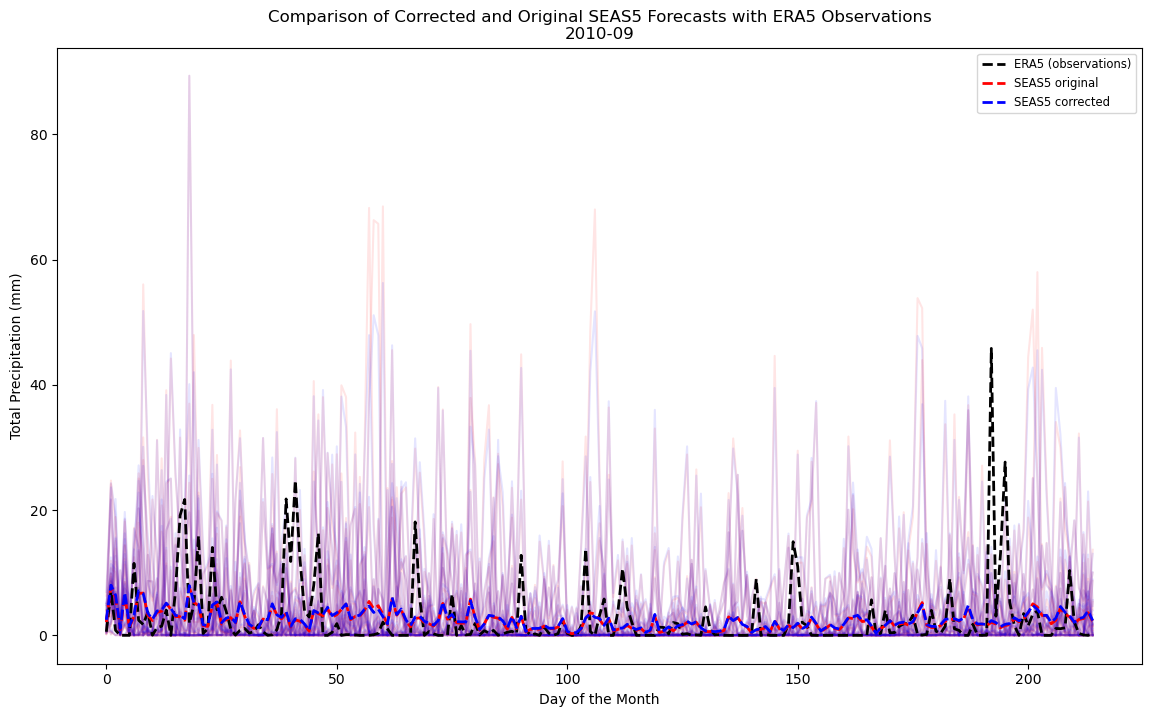

In [51]:
# Create a plot
plt.figure(figsize=(14, 8))

# Plot original SEAS5 data for each member
for member in range(seas5_t.shape[0]):
    plt.plot(seas5_da.sel(member=member+1, month=month, year=year), color="red", alpha=0.1)  #label=f"Original SEAS5 Member {member+1}"

# Plot corrected SEAS5 data for each member
for member in range(seas5_t.shape[0]):
    plt.plot(seas5_corrected[variable][member].values, color="blue", alpha=0.1)  #label=f"Corrected SEAS5 Member {member+1}", 

# Plot ERA5 data
plt.plot(era5_da.sel(month=month, year=year), label="ERA5 (observations)", color="black", linestyle="--", linewidth=2)

# Plot original SEAS5 data for ensemble member
plt.plot(seas5_ensmean.sel(month=month, year=year), label="SEAS5 original", color="red", linestyle="--", linewidth=2)

# Plot corrected SEAS5 data for ensemble member
plt.plot(seas5_bc_ensmean[variable], color="blue", label="SEAS5 corrected", linestyle="--", linewidth=2)


# Adding labels and title
plt.xlabel("Day of the Month")
plt.ylabel("Total Precipitation (mm)")
plt.title(f"Comparison of Corrected and Original SEAS5 Forecasts with ERA5 Observations\n{year}-{month:02d}")
plt.legend(loc="best", fontsize="small", ncol=1)

# Show the plot
plt.show()